In [1]:
#imports
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
from brainglobe_atlasapi.bg_atlas import BrainGlobeAtlas
from brainrender import Scene
from brainrender.actors import Neuron
import vedo
import time
import scanpy as ss

In [2]:
#function definitions
def drop_by_thresh(df, thresh):
    '''
    this is written to drop columns of a data frame that have a sum value of below the input threshold
    df: pandas.DataFrame
    thresh: float
    returns: pandas.DataFrame
    '''
    sum_df = df.apply(np.sum, axis=0)
    mask = sum_df < thresh
    low_endpoint_regions = sum_df[mask].index
    return df.drop(low_endpoint_regions, axis=1)

def load_data_from_dir(direct):
    '''
    load data from a directory into a pandas DataFrame, replaces NaNs with 0s for the purpose of this notebook
    dir: string
    returns: pandas.DataFram
    '''
    data = pd.DataFrame()
    print('Loading files:')
    for file in tqdm(os.listdir(direct)):
        filename = os.path.join(direct, file)
        df = pd.read_csv(filename, header=None)
        df[0] = df[0] + df[1]
        df[1] = df[2]
        del df[2]
        df = df.loc[(df!=0).any(axis=1)]
        df_t = df.transpose()
        file = file.replace('_freq.csv','')
        file = file.replace('_length.csv', '')
        df_t = df_t.rename(index={1: file})
        df_t.columns = df_t.iloc[0]
        df_t = df_t.drop([0])
        data = pd.concat([data, df_t], join='outer')
    data_nonan = data.replace(np.nan, 0)
    return data_nonan

def preprocess(df):
    '''
    preprocess data however I want to, accepts a pandas.DataFrame with no NaNs
    df: pandas.DataFrame
    returns: pandas.DataFrame
    '''
    #remove zero variance columns
    selector = VarianceThreshold(threshold=0.0).set_output(transform='pandas')
    df = selector.fit_transform(df)
    
    #filter out regions that have less than 3 endpoints labeled in that region
    # data_thresh = drop_by_thresh(df, 3)
    # data_toln = data_thresh.copy()
    data_tonorm = df.copy()

    #natural log scale my data, formula of ln(number of terminals + 1) as per Ding et al. 2025
    #maybe instead of log1p i should normalize across cells by percentage, work on this later
    #terriergpt help here
    #tbh this doesn't seem to work super well
    row_sums = data_tonorm.sum(axis=1)
    df_pct = (data_tonorm.div(row_sums, axis=0))*100
    df_log = np.log(df_pct+1)

    return df_log

def cluster_and_plot(df, row_colors=None, **plot_info):
    '''
    hierarchically cluster and plot data using seaborn.clustermap using euclidean distance with ward's linkage
    df: pandas.DataFramea

    plot_info: matplotlib kwargs
    returns: None
    '''
    
    cmap = sns.clustermap(df, 
                  method='ward', 
                  metric='euclidean', 
                  row_cluster=False,
                  dendrogram_ratio=(.1, .15),
                  cbar_pos=(0, .15, .03, .7),
                  cbar_kws={'label': 'ln(terminals in region + 1)'},
                  yticklabels=True,
                  xticklabels=True,
                  row_colors=row_colors)
    
    return cmap

def merge_region_counts(list1, list2):
    # thanks deepseek
    # Create a dictionary to aggregate counts
    region_counts = {}
    
    # Process first list
    for region, count in list1:
        region_counts[region] = region_counts.get(region, 0) + count
    
    # Process second list
    for region, count in list2:
        region_counts[region] = region_counts.get(region, 0) + count
    
    # Convert back to list of tuples
    merged_list = [(region, count) for region, count in region_counts.items()]
    
    return merged_list

In [5]:
#import allen atlas
ccf_v3_10um = BrainGlobeAtlas('allen_mouse_10um')

In [6]:
ccf_v3_10um.structures["CB"]["structure_id_path"]

[997, 8, 512]

In [7]:
#have to change swc coords so this renders correctly, swap x and y around i think?
#will do another time though, not in a rush since i can render in SNT
vedo.settings.default_backend='vtk'
ccf_scene = Scene(atlas_name='allen_mouse_10um')
N032_674185 = Neuron(neuron=r'C:\Users\samkr\OneDrive\Documents\BU\AllenExASPIM\medulla_IRN_PRN_PGRN\json_swc\swc\N032-674185-IB.swc')
ccf_scene.add(N032_674185)
ccf_scene.render(camera='frontal') 

KeyboardInterrupt: 

In [3]:
#data input
#on my PC in lab dir is C:\Users\samkr\OneDrive\Documents\Code\reconstructions\SNT_histos\SNT_histos\frequency
#on shared PC its ...
frequency_dir = input('Input directory with region frequency data: ') #C:\Users\samkr\OneDrive\Documents\Code\reconstructions\SNT_histos\SNT_histos\frequency
#length_dir = input('Input directory with region length data: ') #C:\Users\samkr\OneDrive\Documents\Code\reconstructions\SNT_histos\SNT_histos\length

In [4]:
#load frequency and length data in
frequency_data = load_data_from_dir(frequency_dir)
#length_data = load_data_from_dir(length_dir)
#print("Column variances:", np.var(data, axis=0))

Loading files:


  0%|          | 0/69 [00:00<?, ?it/s]

100%|██████████| 69/69 [00:01<00:00, 52.13it/s]
C:\Users\samkr\AppData\Local\Temp\ipykernel_62416\3392369691.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_nonan = data.replace(np.nan, 0)


In [ ]:
# #dropping mossy fibers so they aren't included in subsequent analyses
# #i guess i don't need to do this, ill include for now but can use this cell if i want to drop
# mossy_list = ['N012-674185-PG', 'N123-708369-HS', 'N017-715345-YV', 'N024-715345-SA', 'N035-674191-FMR', 'N031-715345-DS', 'N041-674191-AR', 'N056-686955-JN', 'N057-686955-SA', 'N113-708369-JN',
#                'N114-708369-HS', 'N115-708369-BP', 'N016-715345-HD', 'N023-715346-PC', 'N037-674185-IB', 'N044-674191-SP']
# for cell in mossy_list:
#     #print(cell)
#     frequency_data = frequency_data.drop(cell)

# print(len(frequency_data.index)) #should be 53, 69 total and 16 mossy fibers

53


In [7]:
#remove 0 variance columns, think they arise over some SNT weirdness but not really sure
selector = VarianceThreshold(threshold=0.0).set_output(transform='pandas')
df_tosum = selector.fit_transform(frequency_data)

In [8]:
df_summed = df_tosum.sum(axis=0)
print(type(df_tosum))
# mask = df_summed > 10
# df_summed = df_summed[mask]
#df_summed = np.sort(df_summed)

<class 'pandas.core.frame.DataFrame'>


In [9]:
#merge the same regions from different hemispheres
zipped_regions = zip(df_tosum.keys(), df_summed)
regions_c = []
regions_i = []
for region, value in zipped_regions:
    #print(region, value)
    expi = 'Ipsilateral'
    expc = 'Contralateral'
    if expi in region:
        reg = region.replace(expi+' ', '')
        regions_i.append((reg, value))
    if expc in region:
        reg2 = region.replace(expc+' ', '')
        regions_c.append((reg2, value))
# print(regions_i)
# print(regions_c)
#check to be sure i didn't lose regions when doing this (not very robust tho)
# for ii in regions_i:
#     ri, vi = ii
#     for ic in regions_c:
#         rc, vc = ic
#         if ri == rc:
#             print(f'{ri} in both hems')
#         continue
merged = merge_region_counts(regions_i, regions_c)
# print(len(merged_regions))
# print(merged_regions)
merged_regions = []
for i in merged:
    k, v = i
    if k == 'Other':
        continue
    else:
        merged_regions.append(i)
        

In [10]:
#get a summary bar plot of the most frequent regions that have significant projections, by percentage of total projections out of the whole dataset
sum = 0
for i in merged_regions:
    k, v = i
    sum += v
percentages = []
for i in merged_regions:
    k, v = i
    perc = (v/sum)*100
    percentages.append((k, perc))
sort_perc = sorted(percentages, key=lambda item: item[1])
sort_perc.reverse()
print(len(sort_perc))
perc_thresh = [(k, v) for k, v in sort_perc if v >= 1]
print(len(perc_thresh))
print(10/sum)
print(merged_regions)

242
23
0.00017266982076872604
[('IRN', 12024.0), ('MDRN', 1229.0), ('VII', 1127.0), ('LIN', 240.0), ('PARN', 5825.0), ('MY', 2356.0), ('GRN', 4155.0), ('PGRN', 103.0), ('V', 957.0), ('XII', 2208.0), ('P', 1513.0), ('P5', 1945.0), ('PRNr', 209.0), ('MARN', 330.0), ('PCG', 33.0), ('LRN', 8.0), ('PHY', 37.0), ('LDT', 13.0), ('RO', 49.0), ('tspc', 136.0), ('PSV', 668.0), ('VNC', 74.0), ('PB', 875.0), ('PRNc', 1098.0), ('uf', 10.0), ('rust', 66.0), ('MTN', 26.0), ('SUT', 1100.0), ('MB', 400.0), ('ILM', 12.0), ('scp', 166.0), ('CB', 94.0), ('SLD', 16.0), ('SPVC', 478.0), ('das', 12.0), ('MRN', 749.0), ('RM', 90.0), ('TRN', 8.0), ('NTS', 1162.0), ('PPN', 150.0), ('x', 26.0), ('sptV', 23.0), ('PAG', 369.0), ('mlf', 30.0), ('Acs5', 145.0), ('SPVI', 710.0), ('DMX', 341.0), ('SPVO', 502.0), ('AMB', 1.0), ('sctv', 7.0), ('I5', 58.0), ('ACVII', 10.0), ('DCN', 3.0), ('SOC', 5.0), ('ISN', 7.0), ('PC5', 16.0), ('ll', 24.0), ('V4', 22.0), ('c', 2.0), ('VIIn', 34.0), ('pyd', 7.0), ('APN', 209.0), ('SCdg


[
    Text(0.5, 1.0, 'Most frequently targeted regions from IRN/PARN'),
    Text(0.5, 0, 'Percentage out of total dataset'),
    Text(0, 0.5, 'region')
]

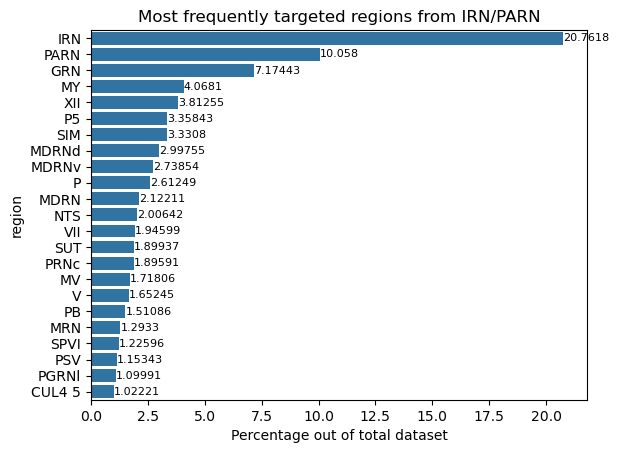

In [11]:
#exclude mossy fibers from this? i dont think its necessary 
x = [k for k, _ in perc_thresh]
y = [v for _, v in perc_thresh]
ax = sns.barplot(x=y, y=x)
ax.bar_label(ax.containers[0], fontsize=8)
ax.set(title='Most frequently targeted regions from IRN/PARN', xlabel='Percentage out of total dataset', ylabel='region')

In [12]:
#merge ipsi/contra region frequency values, then preprocess
# for row in frequency_data.iterrows():
#     keys = []
#     values = []
#chat gpt code
ipsi_cols = [col for col in frequency_data.columns if col.startswith('Ipsilateral')]
contra_cols = [col for col in frequency_data.columns if col.startswith('Contralateral')]

# Strip hemisphere prefix to identify shared brain regions
ipsi_regions = [col.replace('Ipsilateral ', '') for col in ipsi_cols]
contra_regions = [col.replace('Contralateral ', '') for col in contra_cols]

# Find shared regions (in case some mismatch exists) (GPT)
#nope actually union of all regions, since there are some regions that only recieve ipsilateral projections
all_regions = set(ipsi_regions) | set(contra_regions)

# Build the new DataFrame
merged_frequency = pd.DataFrame(index=frequency_data.index)

for region in all_regions:
    ipsi_col = f'Ipsilateral {region}'
    contra_col = f'Contralateral {region}'
    
    merged_frequency[region] = frequency_data[ipsi_col] + frequency_data[contra_col]
merged_frequency = merged_frequency.drop(columns=['fiber tracts', 'wholebrain', 'Other'])
print(merged_frequency['IRN'].head())
print(frequency_data['Ipsilateral IRN'] + frequency_data['Contralateral IRN']) #sanity check to see if the value in the given region is the same as summed values from lateralized dataset

AA0434     46.0
AA0503     16.0
AA0947     30.0
AA1196     55.0
AA1313    161.0
Name: IRN, dtype: float64
AA0434             46.0
AA0503             16.0
AA0947             30.0
AA1196             55.0
AA1313            161.0
                  ...  
N128-708369-HS     60.0
N129-708369-YP      5.0
N130-708369-YP     33.0
N132-708369-SA     10.0
N136-708369-SA      0.0
Length: 69, dtype: float64


C:\Users\samkr\AppData\Local\Temp\ipykernel_62416\4174046924.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_frequency[region] = frequency_data[ipsi_col] + frequency_data[contra_col]
C:\Users\samkr\AppData\Local\Temp\ipykernel_62416\4174046924.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_frequency[region] = frequency_data[ipsi_col] + frequency_data[contra_col]
C:\Users\samkr\AppData\Local\Temp\ipykernel_62416\4174046924.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the res

In [13]:
#merged_frequency should allow me to do correlational analysis next time i work on this, as well as other summary histos
merged_ppd = preprocess(merged_frequency)


In [14]:
#data preprocessing
frequency_ppd = preprocess(frequency_data)
#length_ppd = preprocess(length_data)
frequency_tocluster = frequency_ppd.T
#length_tocluster = length_ppd.T
#frequency_tocluster = frequency_tocluster.sort_index(axis=0) #this separates ipsi v contra but for freq the clusters looked cleaner w/o sorting
#merged_frequency should allow me to do correlational analysis next time i work on this, as well as other summary histos
merged_ppd = preprocess(merged_frequency)

In [15]:
print(merged_ppd.keys())

Index(['TTd', 'SSs6a', 'AIp6a', 'cuf', 'LRNm', 'INC', 'TH', 'MED', 'VMH', 'll',
       ...
       'FL', 'DEC', 'LAV', 'RPO', 'Pa4', 'MEV', 'AMBv', 'CENT3', 'P5', 'SPFp'],
      dtype='object', length=240)


[ 0  5 10 15 20 25 30 35 40 45 50 55 60 65 70 75]
Mean number of target regions per cell: 30.91304347826087


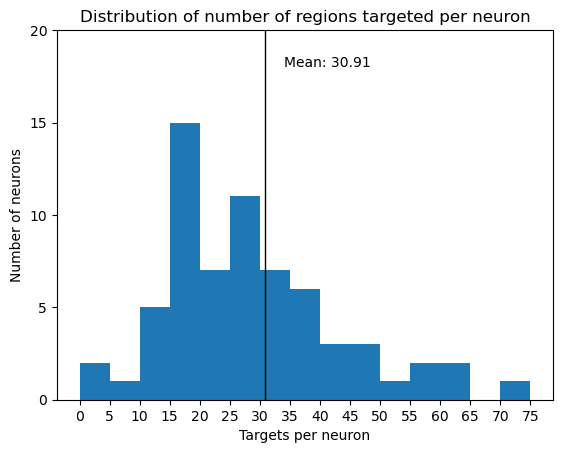

In [16]:
#first gonna do a histo of number of regions targeted
#maybe this should be done on non merged, lets try it quick
true_if_targeted = frequency_ppd > 0 #right now doing it on non merged data think that makes more sense
targets_per_cell = []
for row in true_if_targeted.iterrows():
    sum = 0
    #print(row)
    for info in row:
        for val in info:
            if val is True:
                sum += 1
            else:
                continue
    targets_per_cell.append(sum)
#print(targets_per_cell, len(targets_per_cell))
bins = np.arange(0,80,5)
yrange = np.arange(0,30,5)
print(bins)
target_hist = plt.hist(targets_per_cell, bins=bins)
plt.xticks(bins)
plt.yticks(yrange)
plt.xlabel('Targets per neuron')
plt.ylabel('Number of neurons')
plt.title('Distribution of number of regions targeted per neuron')
plt.axvline(np.mean(targets_per_cell), color='k', linestyle='solid', linewidth=1)
plt.ylim(0, 20)
min_ylim, max_ylim = plt.ylim()
plt.text(np.mean(targets_per_cell)*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(np.mean(targets_per_cell)))
avg_targets = np.mean(targets_per_cell)
print(f'Mean number of target regions per cell: {avg_targets}')

Text(0.5, 1.0, 'Spearman correlation of pontine motif regions')

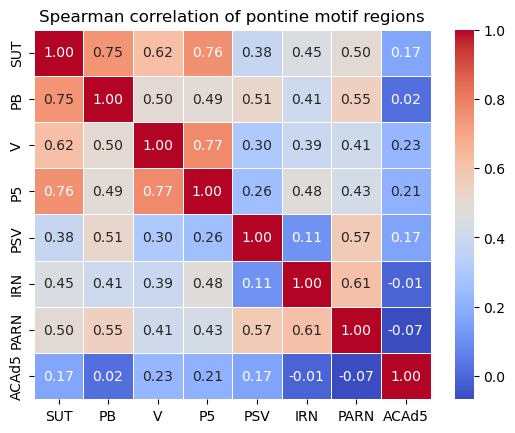

In [17]:
#follow up here is probably some correlation analysis, what regions tend to recieve projections from the same cell 
#(helps investigate that pontine motif that I think I see, are projections to those regions actually correlated?)
#just look at SUT/PB/V/PSV/P5
#use merged_ppd probably? or should i just variance threshold and use without ln scaling
pontine_vals = [merged_ppd.SUT, merged_ppd.PB, merged_ppd.V, merged_ppd.P5, merged_ppd.PSV, merged_ppd.IRN, merged_ppd.PARN, merged_ppd.ACAd5]
#print(type(pontine_vals))
pontine_df = pd.DataFrame(pontine_vals).T
#testing different correlation methods, think spearman is the best? my data isn't necessarily linear?
# methods = ['pearson', 'spearman', 'kendall']
# fig, axes = plt.subplots(1,3,figsize=(15,4))
# for i, method in enumerate(methods):
#     pontine_corr = pontine_df.corr(method=method)
#     sns.heatmap(ax=axes[i], data=pontine_corr, annot=True, fmt='.2f')
#     axes[i].set_title(f'correlation with method: {method}')
pontine_corr = pontine_df.corr(method='spearman')
sns.heatmap(pontine_corr, fmt='.2f', linewidths=0.5, annot=True, cmap='coolwarm')
plt.title('Spearman correlation of pontine motif regions')

Text(0.5, 1.0, 'Cross-correlation of regions that recieved more than 1% of total dataset projections')

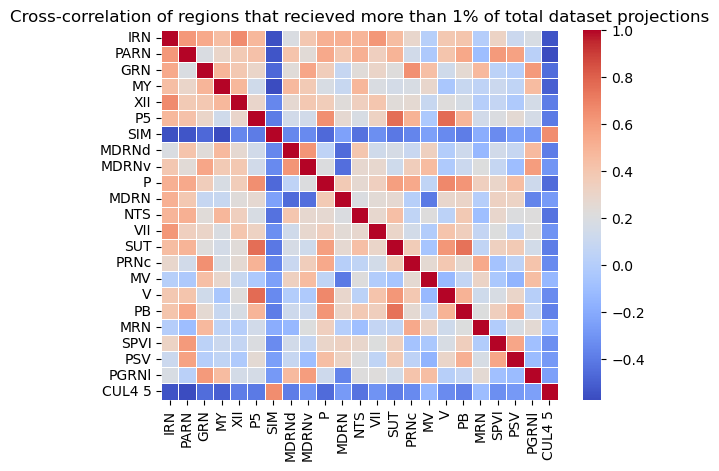

In [18]:
#i think new idea is do this correlation but on the top most targeted regions from before and see if anything sticks out
#mossy fibers now separated out
#theres probably a better way to sort this? honestly not sure what is usually done here, i should just ask some people
to_corr = pd.DataFrame()
for region in x:
    to_corr = pd.concat([to_corr, merged_ppd[region]], axis=1)

to_corr = to_corr
correlated = to_corr.corr(method='spearman')
sns.heatmap(correlated, linewidths=0.5, cmap='coolwarm')
plt.title(r'Cross-correlation of regions that recieved more than 1% of total dataset projections')


c:\Users\samkr\.local\share\mamba\envs\reconstructions\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


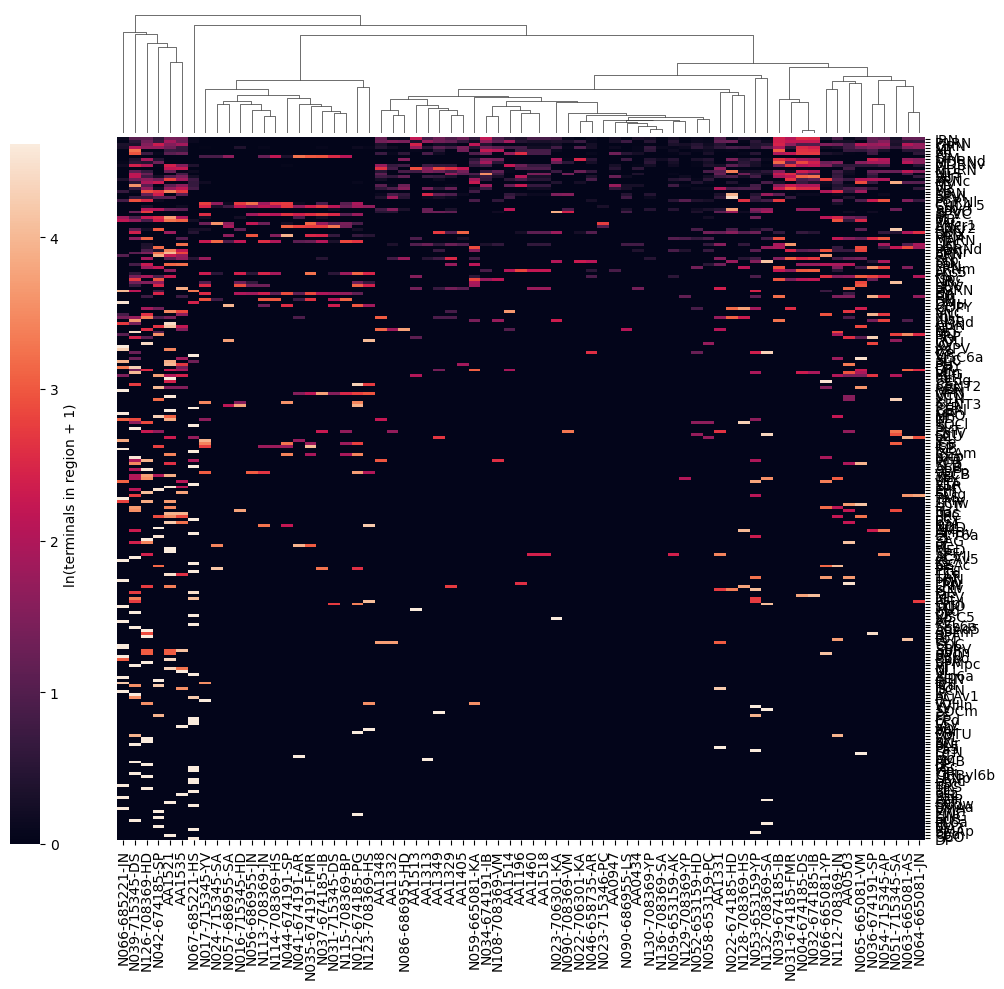

In [134]:
#want to sort my clustermap by highest average proj per region, avg of each region, this is done on merged regions so i can see how to do this, next is to do it on the lateralized dataset
selector = VarianceThreshold(threshold=0.0).set_output(transform='pandas')
merged_frequency = selector.fit_transform(merged_frequency)
#print(merged_frequency.head())
merged_transposed = merged_frequency.T
merged_transposed['mean'] = merged_transposed.mean(axis=1)
sorted_avg = merged_transposed.sort_values('mean', ascending=False)
sorted_avg = sorted_avg.drop(columns=['mean'])
#print(sorted_avg.head())
# avgd_merged = merged_frequency.apply(np.mean, axis=0)
# sorted_avg = avgd_merged.sort_values(ascending=False).head()
for i, row in sorted_avg.iterrows():
    sum = np.sum(row)
    sorted_avg.loc[i] = row.map(lambda x: np.log(((x/sum)*100)+1))
cluster_and_plot(sorted_avg)

In [26]:
#want to remove 'fiber tracts', 'wholebrain', 'Other'
#idk what to do with the larger region annotations (MY, P, etc)
regions = list(merged_frequency.keys())
print(regions)
print(merged_frequency.head())

['CEAc', 'amc', 'SOCm', 'chpl', 'COPY', 'EPd', 'XII', 'vVIIIn', 'VIIn', 'FN', 'LIN', 'ORBvl6b', 'P', 'PMv', 'TRN', 'GPi', 'INC', 'DN', 'y', 'IRN', 'c', 'RM', 'TMv', 'PRM', 'APN', 'sV', 'PYR', 'sctv', 'gVIIn', 'UVU', 'SPVI', 'csc', 'GR', 'NOD', 'mlf', 'VISC5', 'SBPV', 'LRNp', 'nst', 'AP', 'PAL', 'IA', 'SCiw', 'MD', 'FF', 'SPVC', 'MED', 'DMX', 'IMD', 'TTd', 'PF', 'MPN', 'ts', 'MV', 'TRS', 'SOC', 'SLC', 'PCG', 'VII', 'uf', 'MTN', 'CB', 'PVi', 'CU', 'LSc', 'CP', 'FL', 'ACB', 'AMBv', 'DCO', 'PARN', 'AHN', 'SPFm', 'MEV', 'LRN', 'SUT', 'CLI', 'PIL', 'MDRNd', 'ml', 'PL5', 'bic', 'PAS', 'NTS', 'ILM', 'll', 'bsc', 'fx', 'mcp', 'RO', 'DMH', 'ANcr2', 'ICc', 'arb', 'HY', 'py', 'RN', 'DEC', 'I5', 'SNr', 'CEAm', 'RPA', 'PHY', 'scp', 'TH', 'VM', 'PB', 'LRNm', 'AMB', 'LP', 'ECT6a', 'PGRNl', 'act', 'LAV', 'SPF', 'IO', 'LDT', 'PVT', 'PH', 'RT', 'SOCl', 'ANcr1', 'TU', 'PL6a', 'RPF', 'PPY', 'Su3', 'FOTU', 'EW', 'AVPV', 'CS', 'STN', 'PoT', 'MPO', 'SI', 'SPVO', 'LING', 'SCig', 'AIp6a', 'Eth', 'SPA', 'SUV', '

In [ ]:
# #another good plot would be dist of soma location, how many in IRN/PARN/PGRNd, can pull that info from SNT I think just might have to hardcode it here
# #use brainrender to plot some diagrams of exact soma location
# #this will only be including the ones that we got recently, none of the "AA" ones since I don't have swc's
# #kernel keeps dying here, gonna comment it all out for now and return later this week
# #vedo.settings.default_backend='vtk'
# swc_dir = input('Input directory with SWC files: ') #C:\Reconstructions\registered_MY_IRN_PARN_PGRN\medulla_IRN_PRN_PGRN\modfied_swc
# file_list = os.listdir(swc_dir)
# neurons = []
# timelist= []
# for file in file_list:
#     start = time.perf_counter()
#     filepath = os.path.join(swc_dir, file)
#     parts1 = file.split('.')
#     f = parts1[0]
#     parts2 = f.split("_")
#     file = parts2[1]
#     #print(file)
#     neuron = Neuron(filepath)
#     neurons.append(neuron)
#     end = time.perf_counter()
#     print(f'Loaded {file} as Neuron! Took {end-start} seconds')
#     timelist.append(end-start)

# print(f'Avg time to load file: {np.mean(timelist)}')
# print(f'max time to load file: {np.max(timelist)}')
# print(f'min time to load file: {np.min(timelist)}')
# print(f'Total time to load files: {np.sum(timelist)}')

Loaded N004-674185-DS as Neuron! Took 29.537297300063074 seconds
Loaded N012-674185-PG as Neuron! Took 11.979704600060359 seconds
Loaded N016-715345-HD as Neuron! Took 8.07314969995059 seconds
Loaded N017-715345-YV as Neuron! Took 9.360950600006618 seconds
Loaded N022-674185-HD as Neuron! Took 22.126412900048308 seconds
Loaded N022-706301-KA as Neuron! Took 3.5372302999021485 seconds
Loaded N023-706301-KA as Neuron! Took 7.595913300057873 seconds
Loaded N023-715346-PC as Neuron! Took 3.9302873000269756 seconds
Loaded N024-715345-SA as Neuron! Took 8.420850499998778 seconds
Loaded N031-674185-FMR as Neuron! Took 24.707146300002933 seconds
Loaded N031-715345-DS as Neuron! Took 9.5520079000853 seconds
Loaded N032-674185-IB as Neuron! Took 27.852569399983622 seconds
Loaded N034-674191-IB as Neuron! Took 13.249309099977836 seconds
Loaded N035-674191-FMR as Neuron! Took 13.926991400076076 seconds
Loaded N036-674191-SP as Neuron! Took 14.189412000006996 seconds
Loaded N037-674185-IB as Neuron

: 

In [ ]:
#setting lists so I can get ontology information for each region
#think this is unneeded now
regions = frequency_ppd.keys()
regions_target_contra = []
regions_target_ipsi = []
for region in regions:
    expi = 'Ipsilateral'
    expc = 'Contralateral'
    if expi in region:
        #reg = region.replace(expi+' ', '')
        regions_target_ipsi.append(region)
    if expc in region:
        #reg2 = region.replace(expc+' ', '')
        regions_target_contra.append(region)
regions_target_ipsi.remove('Ipsilateral Other') #'other' and 'wholebrain are gone already? guess I removed them earlier in my code but tbh im not sure where (maybe in place modified at some point bc jupyter)
regions_target_contra.remove('Contralateral Other')
regions_target_ipsi.remove('Ipsilateral wholebrain')
#regions_target_contra.remove('wholebrain')
#print(regions_target_ipsi)



In [28]:

#okay ideas, do this stuff but on the lateralized dataset so i can get parent ont level, then sort by that then avg strength
#although if i want to eventually do it on the lateralized dataset, this is a beginning, maybe i should sort these then concatenate, then append this to the end of the lateralized dataset 
#to get a column that is the parent region of each child region
for i, region in enumerate(regions_target_ipsi):
    if region == 'Ipsilateral CUL4 5':
        regions_target_ipsi[i] = 'Ipsilateral CUL4, 5'
for i, region in enumerate(regions_target_contra):
    if region == 'Contralateral CUL4 5':
        regions_target_contra[i] = 'Contralateral CUL4, 5'
#print(regions_target)
parent_regions_ipsi = []
parent_regions_contra = []
for val in regions_target_contra:
    val1 = val.replace('Contralateral ', '')
    parent_i = ccf_v3_10um.structures[val1]['structure_id_path'][-2]
    parent_regions_contra.append((val, parent_i))
#print(parent_regions)
for val in regions_target_ipsi:
    val2 = val.replace('Ipsilateral ', '')
    parent_c = ccf_v3_10um.structures[val2]['structure_id_path'][-2]
    parent_regions_ipsi.append((val, parent_c))
#print(parent_regions)

In [29]:
if 'fiber tracts' in parent_regions_ipsi:
    print('fiber in ipsi parent list')
if 'Ipsilateral fiber' in parent_regions_ipsi:
    print('Ipsilateral fiber in parent ipsi list')
else:
    print('fiber not in ipsi list')
if 'fiber' in parent_regions_contra:
    print('fiber in contra parent list')
if 'Contralateral fiber' in parent_regions_contra:
    print('Contralateral fiber in parent ipsi list')
else:
    print('fiber not in contra list')
    

fiber not in ipsi list
fiber not in contra list


In [30]:
#get each region with parent ontology level (might have to do this manually since some regions don't have the tag I want)
#doing this manually earlier although it may be a lil tedious well see
tandp_contra = list(zip(regions_target_contra, parent_regions_contra))
#sorting just gets it so all regions that have the same parent region are grouped together
sorted_contra = sorted(tandp_contra, key=lambda item: item[1])
#print(sorted_contra)
tandp_ipsi = list(zip(regions_target_ipsi, parent_regions_ipsi))
sorted_ipsi = sorted(tandp_ipsi, key=lambda item: item[1])
#print(sorted_ipsi)
ip_then_cont = sorted_ipsi + sorted_contra
#print(ip_then_cont)
i_to_c_correct_regions = []
for info in ip_then_cont:
    region, parent = info
    if 'CUL4, 5' in region:
        parts = region.split(' ')
        parts[1] = parts[1]+' '+parts[2]
    else:
        parts = region.split(' ')
    parent_path = ccf_v3_10um.structures[parts[1]]["structure_id_path"]
    if len(parent_path) <= 4:
        i_to_c_correct_regions.append((region, ccf_v3_10um.structures[parent_path[-1]]['acronym']))
    else:
        i_to_c_correct_regions.append((region, ccf_v3_10um.structures[parent_path[4]]['acronym']))
sorted_ic = sorted(i_to_c_correct_regions, key=lambda item: item[1])
row_labels = [info[1] for info in sorted_ic]
print(row_labels)

KeyError: 'fiber'

In [ ]:
print(i_to_c_correct_regions)

[('ICe', 'MBsen'), ('ICd', 'MBsen'), ('ICc', 'MBsen'), ('CB', 'CB'), ('ACAv1', 'CTXpl'), ('PF', 'TH'), ('PIL', 'TH'), ('V4', 'V4'), ('c', 'c'), ('V3', 'V3'), ('VL', 'VL'), ('chpl', 'chpl'), ('AIp6a', 'CTXpl'), ('AMBd', 'MY'), ('AMBv', 'MY'), ('PO', 'TH'), ('Eth', 'TH'), ('LP', 'TH'), ('DMH', 'HY'), ('AVPV', 'HY'), ('MPO', 'HY'), ('PVpo', 'HY'), ('SBPV', 'HY'), ('ADP', 'HY'), ('NR', 'MY'), ('PRP', 'MY'), ('PVi', 'HY'), ('DR', 'MBsta'), ('CLI', 'MBsta'), ('IF', 'MBsta'), ('sptV', 'sV'), ('LRNm', 'MY'), ('LRNp', 'MY'), ('LSv', 'STR'), ('LSc', 'STR'), ('IA', 'STR'), ('ZI', 'HY'), ('STN', 'HY'), ('TU', 'HY'), ('SCdg', 'MBmot'), ('SCiw', 'MBmot'), ('SCdw', 'MBmot'), ('SCig', 'MBmot'), ('BMAa', 'CTXsp'), ('BMAp', 'CTXsp'), ('MRN', 'MBmot'), ('PAG', 'MBmot'), ('CUN', 'MBmot'), ('RN', 'MBmot'), ('VTA', 'MBmot'), ('SNr', 'MBmot'), ('uf', 'scp'), ('sctv', 'scp'), ('SCO', 'MBsen'), ('MEV', 'MBsen'), ('SAG', 'MBsen'), ('MB', 'MB'), ('PPN', 'MBsta'), ('IRN', 'MY'), ('MDRN', 'MY'), ('VII', 'MY'), ('L

In [ ]:
for i, region in enumerate(row_labels)

SyntaxError: expected ':' (2360213003.py, line 1)

In [ ]:
unique = []
for region in row_labels:
    if region not in unique:
        unique.append(region)
    else:
        continue
print(len(unique))
print(unique)

53
['AQ', 'CB', 'CTXpl', 'CTXsp', 'DN', 'FN', 'HEM', 'HY', 'IP', 'MB', 'MBmot', 'MBsen', 'MBsta', 'MY', 'P', 'PAL', 'STR', 'TH', 'V3', 'V4', 'V4r', 'VERM', 'VIIn', 'VL', 'VeCB', 'act', 'amc', 'arb', 'bsc', 'c', 'cVIIIn', 'cett', 'chpl', 'cpd', 'csc', 'fa', 'fiber tracts', 'fxs', 'gVIIn', 'icp', 'mcp', 'mfbse', 'mlf', 'nst', 'pc', 'py', 'pyd', 'rust', 'sV', 'scp', 'ts', 'tspc', 'vVIIIn']


In [ ]:
ccf_v3_10um.structures['CTXpl']['structure_id_path']

[997, 8, 567, 688, 695]

In [ ]:
ccf_v3_10um.structures[140]


{
    'acronym': 'AQ',
    'id': 140,
    'name': 'cerebral aqueduct',
    'structure_id_path': [997, 73, 140],
    'rgb_triplet': [170, 170, 170],
    'mesh_filename': WindowsPath('C:/Users/samkr/.brainglobe/allen_mouse_10um_v1.2/meshes/140.obj'),
    'mesh': <meshio mesh object>
  Number of points: 521
  Number of cells:
    triangle: 1034
  Point data: obj:vn
  Cell data: obj:group_ids
}

In [ ]:
#testing what color labels should be
iris = sns.load_dataset("iris")
species = iris.pop("species")
lut = dict(zip(species.unique(), "rbg"))
print(lut)
row_colors = species.map(lut)
print(row_colors)
unique = []
for color in row_colors:
    if color not in unique:
        unique.append(color)
    else:
        continue
print(len(unique))

{'setosa': 'r', 'versicolor': 'b', 'virginica': 'g'}
0      r
1      r
2      r
3      r
4      r
      ..
145    g
146    g
147    g
148    g
149    g
Name: species, Length: 150, dtype: object
3


In [118]:
frequency_tocluster.head()

AA0434    AA0503    AA0947    AA1196    AA1313    AA1329  \
Ipsilateral IRN   3.547343  1.193574  2.574230  2.261112  3.156406  2.762990   
Ipsilateral MDRN  2.332370  1.193574  1.511903  1.417066  2.077344  2.414952   
Ipsilateral VII   1.918972  0.000000  0.000000  0.000000  0.000000  1.854067   
Ipsilateral LIN   1.501490  0.000000  0.000000  0.000000  0.608672  0.000000   
Ipsilateral PARN  1.201645  1.102436  2.023619  1.842532  3.626796  2.502104   

                    AA1331    AA1332    AA1348    AA1349  ...  N113-708369-JN  \
Ipsilateral IRN   3.378270  0.432133  2.345066  2.989808  ...        0.000000   
Ipsilateral MDRN  1.934416  1.565232  2.172820  2.574961  ...        0.000000   
Ipsilateral VII   1.640937  0.000000  0.000000  0.000000  ...        0.000000   
Ipsilateral LIN   0.891998  0.239230  0.000000  0.191422  ...        0.000000   
Ipsilateral PARN  3.036874  3.693598  1.679562  2.034126  ...        0.335333   

                  N114-708369-HS  N115-708369-BP  N123-708369-HS  \
Ipsilateral IRN              0.0             0.0             0.0   
Ipsilateral MDRN             0.0             0.0             0.0   
Ipsilateral VII              0.0             0.0             0.0   
Ipsilateral LIN              0.0             0.0             0.0   
Ipsilateral PARN             0.0             0.0             0.0   

                  N126-708369-HD  N128-708369-HS  N129-708369-YP  \
Ipsilateral IRN         2.426496        2.744903         1.53393   
Ipsilateral MDRN        0.000000        0.000000         0.00000   
Ipsilateral VII         0.845777        2.114031         0.00000   
Ipsilateral LIN         0.000000        0.395709         0.00000   
Ipsilateral PARN        1.851967        0.678477         0.00000   

                  N130-708369-YP  N132-708369-SA  N136-708369-SA  
Ipsilateral IRN         2.185460        0.777705             0.0  
Ipsilateral MDRN        0.000000        0.000000             0.0  
Ipsilateral VII         0.000000        0.462624             0.0  
Ipsilateral LIN         0.000000        0.000000             0.0  
Ipsilateral PARN        2.650272        0.137201             0.0  

[5 rows x 69 columns]

['#12ff0a', '#12ff0a', '#12ff0a', '#12ff0a', '#12ff0a', '#12ff0a', '#12ff0a', '#12ff0a', '#12ff0a', '#12ff0a', '#12ff0a', '#12ff0a', '#12ff0a', '#12ff0a', '#12ff0a', '#12ff0a', '#12ff0a', '#12ff0a', '#12ff0a', '#00fff2fc', '#00fff2fc', '#00fff2fc', '#00fff2fc', '#00fff2fc', '#00fff2fc', '#00fff2fc', '#00fff2fc', '#00fff2fc', '#00fff2fc', '#00fff2fc', '#00fff2fc', '#00fff2fc', '#00fff2fc', '#c70000', '#c70000', '#c70000', '#c70000', '#c70000', '#c70000', '#c70000', '#c70000', '#c70000', '#c70000', '#c70000', '#c70000', '#c70000', '#c70000', '#c70000', '#c70000', '#c70000', '#c70000', '#ff7676', '#ff7676', '#ff7676', '#ff7676', '#ff7676', '#ff7676', '#ff7676', '#ff7676', '#ff7676', '#ff7676', '#ff7676', '#ff7676', '#ff7676', '#ff7676', '#ff7676', '#ff7676', '#ff7676', '#ff7676', '#ff7676', '#ff7676', '#ff7676', '#ff01ea', '#ff01ea', '#ff01ea', '#ff01ea', '#ff01ea', '#ff01ea', '#ff01ea', '#ff01ea', '#ff01ea', '#ff01ea', '#ff01ea', '#ff01ea', '#ff01ea', '#ff01ea', '#ff01ea', '#ff01ea', '#f

c:\Users\samkr\.local\share\mamba\envs\reconstructions\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


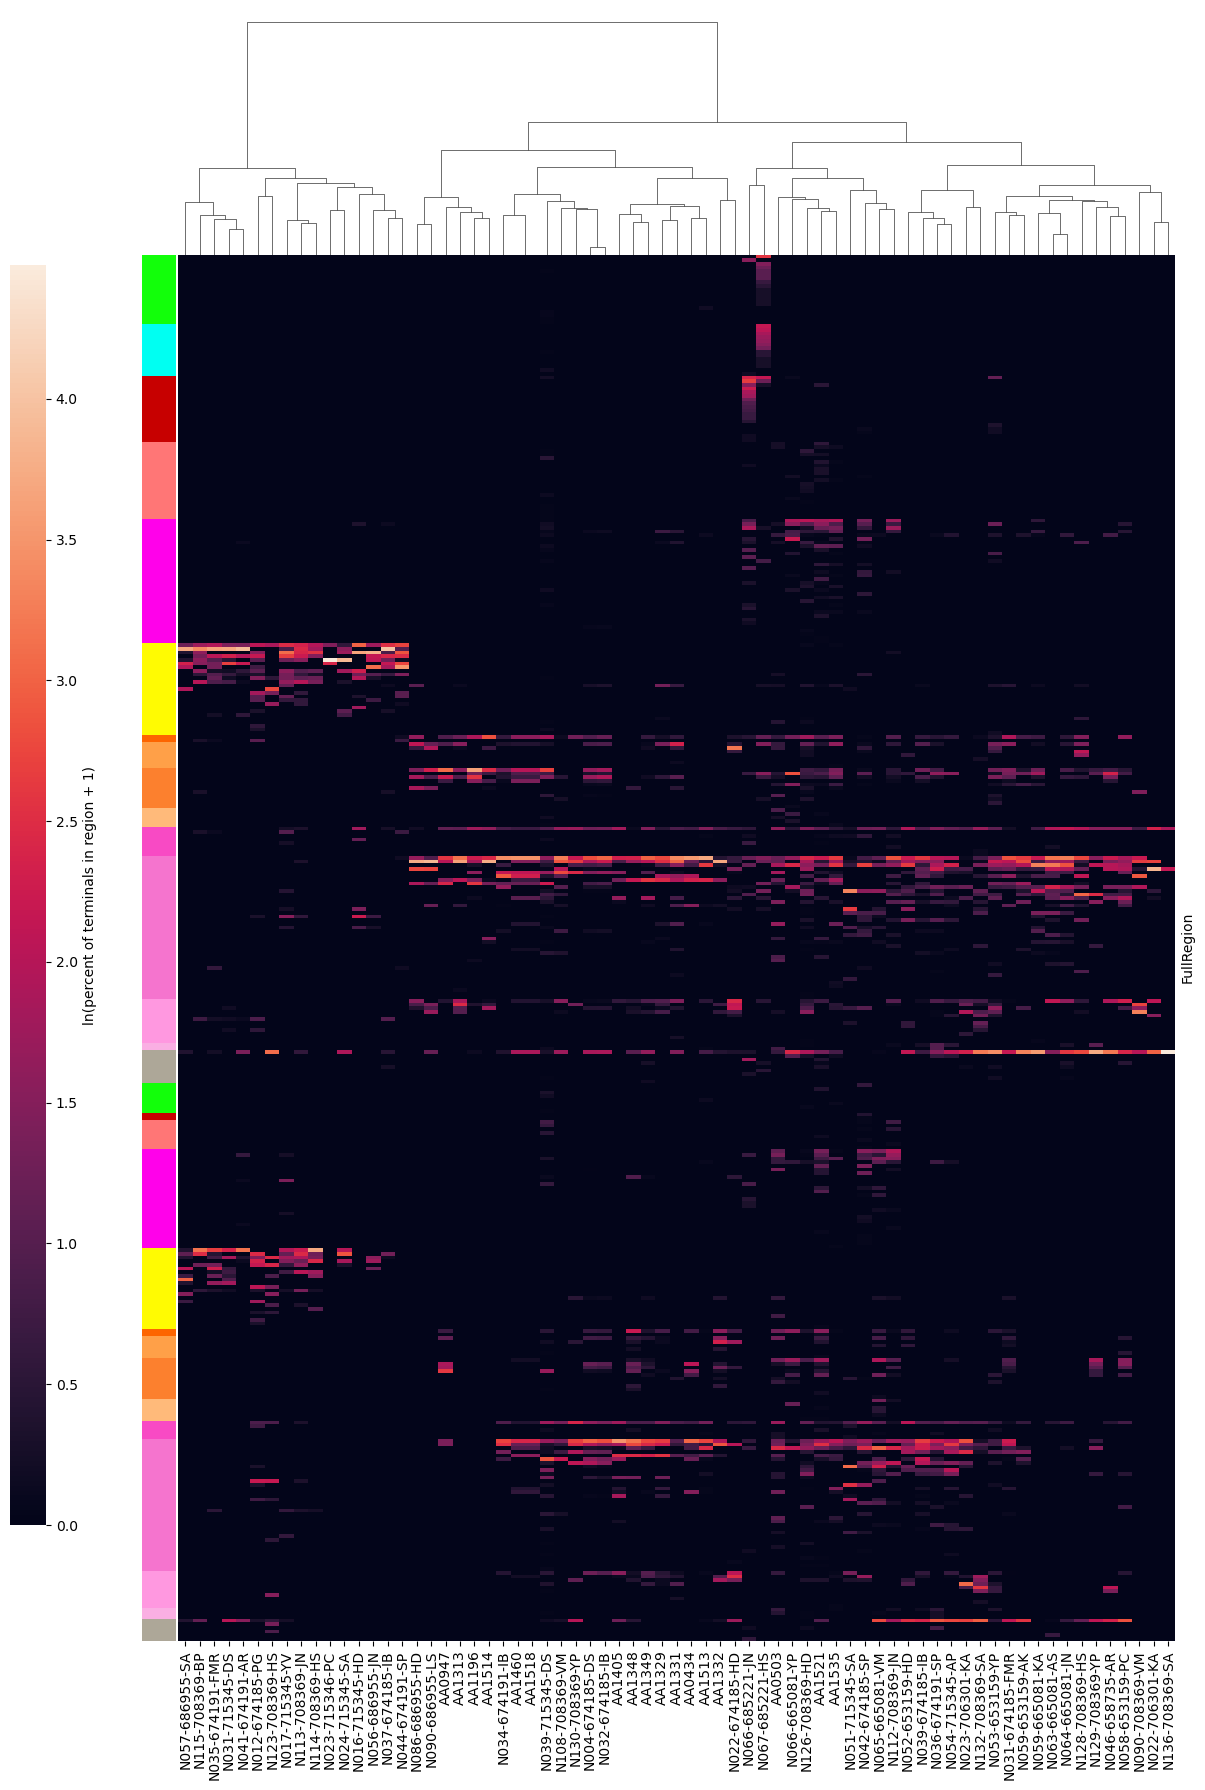

In [21]:
annot = pd.read_csv('region_list_for_annotation.csv')
#frequency_tocluster['Mean'] = np.mean(frequency_tocluster, axis=1)
index_df = pd.DataFrame({'FullRegion': frequency_tocluster.index})
index_df = index_df.merge(annot, left_on='FullRegion', right_on='Region', how='left')
index_df[['Laterality', 'Region']] = index_df['Region'].str.extract(r'^(Ipsilateral|Contralateral) (.+)$')
index_df['MeanProjection'] = frequency_tocluster.mean(axis=1).values

laterality_order = {'Ipsilateral': 0, 'Contralateral': 1}
index_df['LateralityOrder'] = index_df['Laterality'].map(laterality_order)

ontology_order = {'CTX':0, 'CNU':1, 'HY':2, 'TH':3, 'MB':4, 'CB':5, 'P':6, 'P-sen':7, 'P-mot':8,
                 'P-sat':9, 'MY':10, 'MY-mot':11, 'MY-sen':12, 'MY-sat':13, 'Other':14}  # adjust for your ontology levels
index_df['OntologyOrder'] = index_df['Ontology'].map(ontology_order)
sorted_index = index_df.sort_values(by=['LateralityOrder', 'OntologyOrder', 'MeanProjection'], ascending=[True, True, False])
freq_sorted = frequency_tocluster.reindex(sorted_index['FullRegion'])
#print(freq_sorted)
ont_lut = {
    0: "#12ff0a",  
    2: "#c70000",   
    3: "#ff7676",   
    4: "#ff01ea",   
    5: "#fffb02",   
    7: "#ffa048",
    8: "#fc802e",
    9: "#ffba7a",
    6: "#fd6500",    
    11: "#f574ce",
    12: "#ff98e0",
    13: "#faafe3",
    10: "#f84ac4",
    14:  "#ada798fd",
    1: "#00fff2fc"  
}
row_colors = list(sorted_index['OntologyOrder'].map(ont_lut))
print(row_colors)
sns.clustermap(freq_sorted,
    method='ward',
    metric='euclidean',
    row_cluster=False,
    col_cluster=True,
    row_colors=row_colors,
    dendrogram_ratio=(.1, .15),
    cbar_pos=(0, .15, .03, .7),
    cbar_kws={'label': 'ln(percent of terminals in region + 1)'},
    yticklabels=False,
    xticklabels=True,
    figsize=(12, 18),         # wider figure for right axis
)

c:\Users\samkr\.local\share\mamba\envs\reconstructions\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


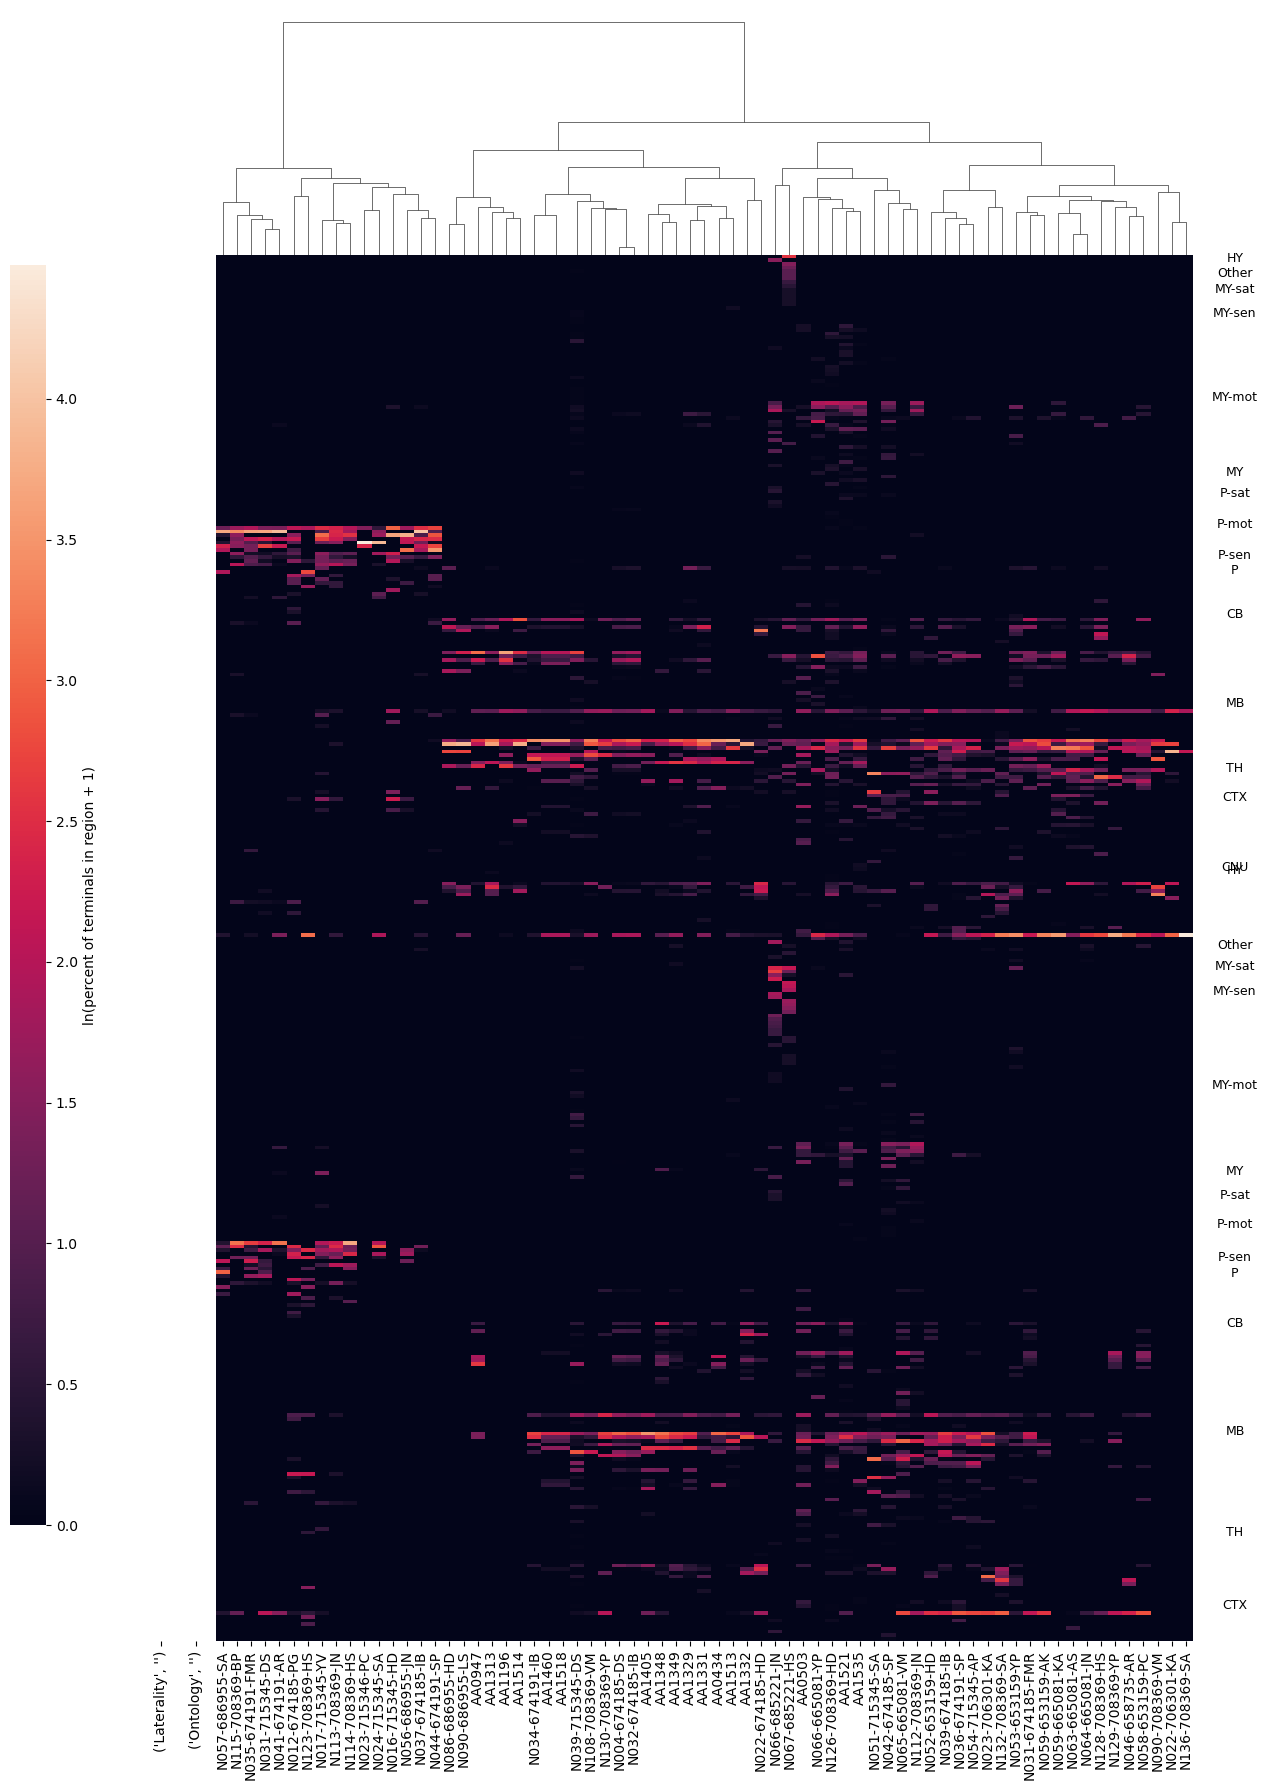

In [148]:
#terriergpt
# frequency_tocluster: regions (rows) x neurons (cols)
# Your annotation file with columns "Region" and "Ontology"
annot = pd.read_csv('region_list_for_annotation.csv')

# Create a DataFrame to hold metadata for sorting, starting with the full region string (including laterality)
index_df = pd.DataFrame({'RegionFull': frequency_tocluster.index})

# Extract laterality and region for sorting purpose, but merge will be done on full string
index_df[['Laterality', 'Region']] = index_df['RegionFull'].str.extract(r'^(Ipsilateral|Contralateral) (.+)$')

# Merge annotation on full region string
index_df = index_df.merge(annot, left_on='RegionFull', right_on='Region', how='left')

# Check for missing ontologies
missing = index_df[index_df['Ontology'].isna()]
if not missing.empty:
    print("Warning: Missing ontology for these regions:")
    print(missing['RegionFull'].tolist())

# Map laterality order
laterality_order = {'Ipsilateral': 0, 'Contralateral': 1}
index_df['LateralityOrder'] = index_df['Laterality'].map(laterality_order)

# Define ontology order, categorical dtype
ontology_order = ['CTX', 'CNU' 'HY', 'TH', 'MB', 'CB', 'P', 'P-sen', 'P-mot', 'P-sat', 'MY', 'MY-mot', 'MY-sen', 'MY-sat', 'Other']  # adjust for your ontology levels
index_df['OntologyOrder'] = pd.Categorical(index_df['Ontology'], categories=ontology_order, ordered=True)

# Get mean projection per region (row)
index_df['MeanProjection'] = frequency_tocluster.mean(axis=1).values

# Sort by laterality, ontology, then mean projection descending
sorted_index_df = index_df.sort_values(
    by=['LateralityOrder', 'OntologyOrder', 'MeanProjection'],
    ascending=[True, True, False]
)

# Reindex freq_t with the fully sorted full region strings
sorted_tocluster = frequency_tocluster.loc[sorted_index_df['RegionFull']]

# Example ontology palette; customize as needed
#['CTX', 'HY', 'TH', 'MB', 'CB', 'P', 'MY', 'MY-mot', 'Other',
       #'P-mot', 'MY-sen', 'P-sen', 'MY-sat', 'CNU', 'P-sat']
ontology_palette = {
    'CTX': "#12ff0a",  # blue
    'HY': "#c70000",   # orange
    'TH': "#ff7676",   # green
    'MB': "#ff01ea",   # red
    'CB': "#fffb02",   # purple
    'P-sen': "#ffa048",
    'P-mot': "#fc802e",
    'P-sat': "#ffba7a",
    'P': "#fd6500",    # brown
    'MY-mot': "#f574ce",
    'MY-sen': "#ff98e0",
    'MY-sat': "#faafe3",
    'MY': "#f84ac4",
    'Other':  "#ada798fd",
    'CNU': "#00fff2fc"  # pink
}

# Laterality palette
laterality_palette = {
    'Ipsilateral': '#17becf',  # cyan
    'Contralateral': '#bcbd22',  # olive
}

row_colors = pd.DataFrame({
    'Laterality': sorted_index_df['Laterality'].map(laterality_palette),
    'Ontology': sorted_index_df['Ontology'].map(ontology_palette),
})
row_colors.columns = pd.MultiIndex.from_tuples([('Laterality', ''), ('Ontology', '')])
# 1. Strip whitespace in ontology strings
sorted_index_df['Ontology'] = sorted_index_df['Ontology'].str.strip()

# 2. Check for missing palette keys
missing_ontologies = set(sorted_index_df['Ontology']) - set(ontology_palette.keys())
if missing_ontologies:
    print("Warning: Missing ontology keys in palette:", missing_ontologies)

# 3. Fill missing with fallback color
row_colors = pd.DataFrame({
    'Laterality': sorted_index_df['Laterality'].map(laterality_palette).fillna('#BBBBBB'),
    'Ontology': sorted_index_df['Ontology'].map(ontology_palette).fillna('#BBBBBB'),
})
row_colors.columns = pd.MultiIndex.from_tuples([('Laterality', ''), ('Ontology', '')])

g = sns.clustermap(
    sorted_tocluster,
    method='ward',
    metric='euclidean',
    row_cluster=False,
    col_cluster=True,
    row_colors=row_colors,
    dendrogram_ratio=(.1, .15),
    cbar_pos=(0, .15, .03, .7),
    cbar_kws={'label': 'ln(percent of terminals in region + 1)'},
    yticklabels=False,
    xticklabels=True,
    figsize=(12, 18),         # wider figure for right axis
)

# g.figure.subplots_adjust(left=0.25)  # Adjust left margin

# label_ax = g.ax_row_colors[1]   # Ontology colorbar axis

# label_ax.tick_params(left=False, labelleft=False)
# label_ax.set_ylabel('')

# labels_order = sorted_index_df.reset_index(drop=True)
# grouped = labels_order.groupby(['Laterality', 'Ontology'], sort=False)

# n_rows = len(sorted_tocluster)

# for (laterality, ontology), group in grouped:
#     start = group.index.min()
#     end = group.index.max()
#     ypos = (start + end) / 2
#     ypos_inverted = n_rows - ypos - 1

#     label_ax.text(
#         x=0.8,  # adjust this to position text nicely right of color bar
#         y=ypos_inverted,
#         s=f"{ontology} ({laterality})",
#         ha='left',
#         va='center',
#         fontsize=9,
#         rotation=0,
#         clip_on=False,
#         color='black',
#         transform=label_ax.transData
#     )

fig = g.figure
heatmap_ax = g.ax_heatmap

# Get heatmap position (Bbox in figure coordinates)
pos = heatmap_ax.get_position()

# Define width and height for new axis (small width, full height)
new_ax_width = 0.05  # 5% of figure width
new_ax_height = pos.height
new_ax_left = pos.x1 + 0.01  # small gap after heatmap's right edge
new_ax_bottom = pos.y0

# Add new axes at calculated position
label_ax = fig.add_axes([new_ax_left, new_ax_bottom, new_ax_width, new_ax_height])
label_ax.axis('off')  # Hide all spines, ticks, labels - empty canvas for text

labels_order = sorted_index_df.reset_index(drop=True)
grouped = labels_order.groupby(['Laterality', 'Ontology'], sort=False)

n_rows = len(sorted_tocluster)
for (laterality, ontology), group in grouped:
    start = group.index.min()
    end = group.index.max()
    ypos = (start + end) / 2

    # Invert y to match heatmap orientation: 0 at top
    ypos_inverted = n_rows - ypos - 1

    label_ax.text(
        x=0.5,  # center horizontally in label_ax
        y=ypos_inverted,
        s=f"{ontology}",
        ha='center',
        va='center',
        fontsize=9,
        rotation=0,
        clip_on=False
    )

# Set y-limits and invert to match heatmap
label_ax.set_ylim(-0.5, n_rows - 0.5)
label_ax.invert_yaxis()

In [112]:
index_df.head()

RegionFull   Laterality Region_x          Region_y Ontology  \
0   Ipsilateral IRN  Ipsilateral      IRN   Ipsilateral IRN   MY-mot   
1  Ipsilateral MDRN  Ipsilateral     MDRN  Ipsilateral MDRN   MY-mot   
2   Ipsilateral VII  Ipsilateral      VII   Ipsilateral VII   MY-mot   
3   Ipsilateral LIN  Ipsilateral      LIN   Ipsilateral LIN   MY-mot   
4  Ipsilateral PARN  Ipsilateral     PARN  Ipsilateral PARN   MY-mot   

   LateralityOrder OntologyOrder  MeanProjection  
0                0           NaN        1.623696  
1                0           NaN        0.396184  
2                0           NaN        0.411864  
3                0           NaN        0.124902  
4                0           NaN        1.195809

In [125]:
#sort frequency_tocluster by laterality, then by average projection
#to do this maybe i should make a column that has laterality info, then sort on that, then remove column?
#terriergpt
freq_t = frequency_tocluster.T
annot = pd.read_csv('region_list_for_annotation.csv')
index_df = freq_t.index.to_series().str.extract(r'^(Ipsilateral|Contralateral) (.+)$')
index_df.columns = ['Laterality', 'Region']
mean_proj = freq_t.mean(axis=1)
index_df['MeanProjection'] = mean_proj.values
laterality_order = {'Ipsilateral': 0, 'Contralateral': 1}
index_df['LateralityOrder'] = index_df['Laterality'].map(laterality_order)
sorted_index_df = index_df.sort_values(['LateralityOrder', 'MeanProjection'], ascending=[True, False])
sorted_tocluster = freq_t.loc[sorted_index_df.index]

In [ ]:
#jus tdone to manually annotate region ontology, not needed anymore
# df_annotation = pd.DataFrame({'Region': sorted_tocluster.index, 'Ontology': ['']*len(sorted_tocluster)})
# df_annotation.to_csv('region_list_for_annotation.csv', index=False)

# print("Region list saved to 'region_list_for_annotation.csv' (with empty ontology column).")

Region list saved to 'region_list_for_annotation.csv' (with empty ontology column).


c:\Users\samkr\.local\share\mamba\envs\reconstructions\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


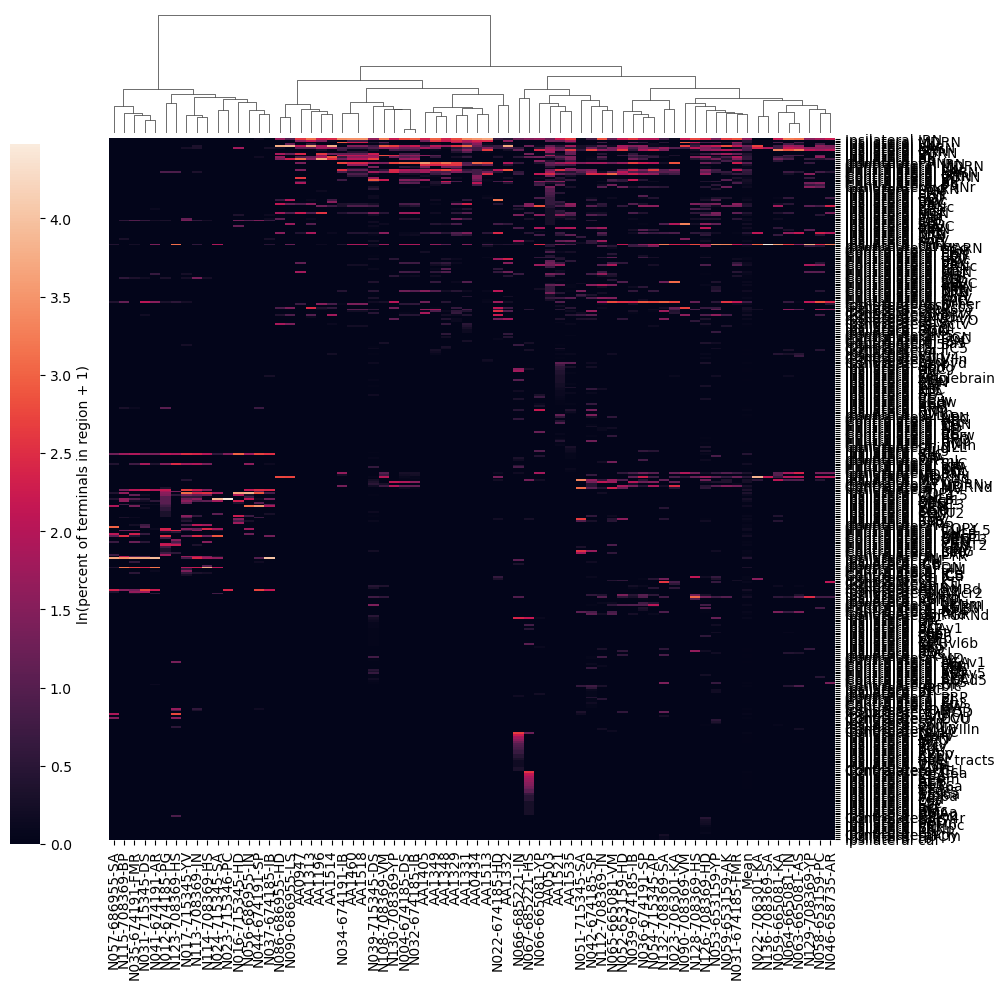

In [126]:
#to get the colors to be correct i may have to manually assign a color to each region, and manually assign region groups since ontology level isn't consistent
#right now this seems like cell size is the biggest split, I should normalize across cells first
sns.clustermap(sorted_tocluster.T, 
                method='ward', 
                metric='euclidean', 
                row_cluster=False,
                dendrogram_ratio=(.1, .15),
                cbar_pos=(0, .15, .03, .7),
                cbar_kws={'label': 'ln(percent of terminals in region + 1)'},
                yticklabels=True,
                xticklabels=True,
                #row_colors=row_labels
                )

c:\Users\samkr\.local\share\mamba\envs\reconstructions\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


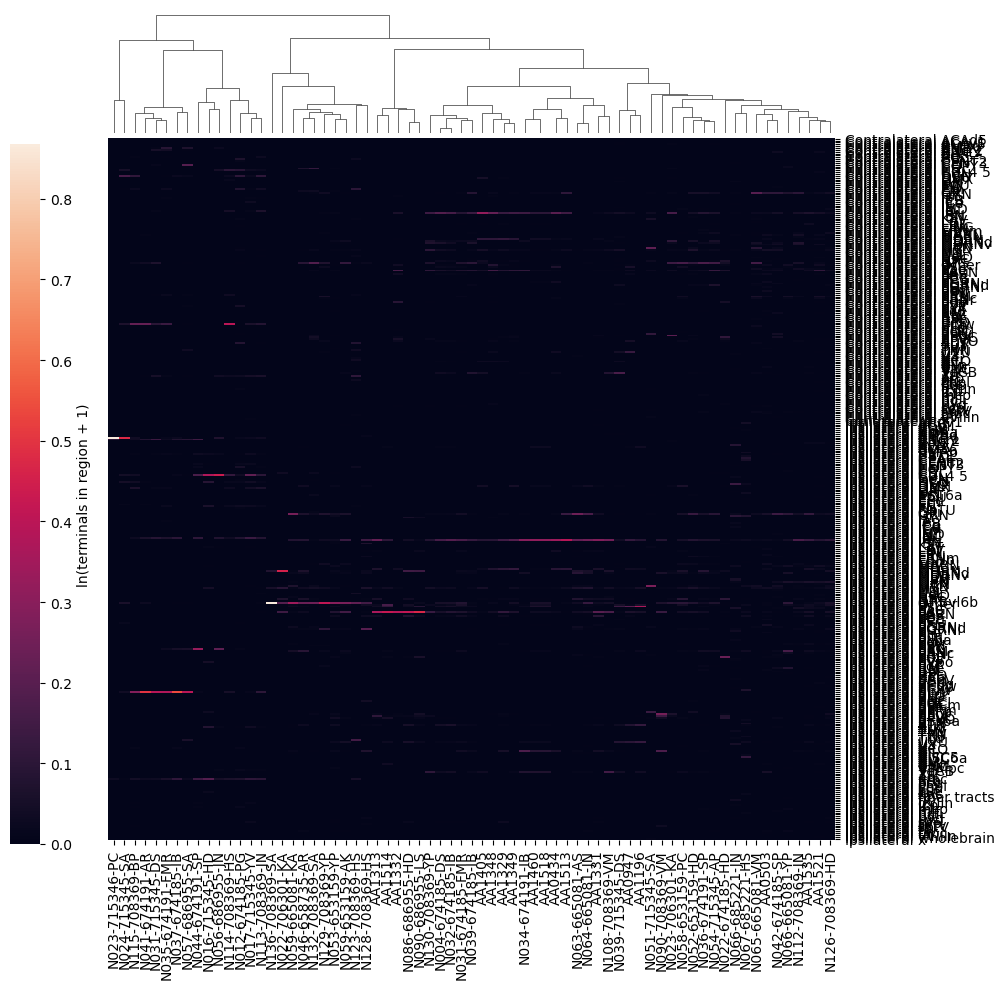

In [64]:
#hierarchical clustering on freq dataset
cmap_freq = cluster_and_plot(frequency_tocluster)
#cmap.plot()
#plt.show()

In [ ]:
#tbh unnecessary work just wanted to work my python skills but its not worth the time rn
selector = VarianceThreshold(threshold=0.0).set_output(transform='pandas')
freq_hasvar = selector.fit_transform(frequency_data)
#print(freq_hasvar.head())
thresh = 5
mask = (freq_hasvar > 0) & (freq_hasvar <= thresh)
#print(mask.head())
rois = []
for i, row in mask.iterrows():
    rowroi = []
    for col, val in row.items():
        if val is True:
            rowroi.append((col, val))
        rois.append(rowroi)
#print(rois)
#idek what i was doing here anymore lmao

[[('Ipsilateral MDRNd', True), ('Ipsilateral NTS', True), ('Ipsilateral PRNr', True), ('Ipsilateral MEV', True), ('Ipsilateral PCG', True), ('Ipsilateral MV', True), ('Contralateral scp', True), ('Contralateral PPN', True), ('Contralateral SPVI', True), ('Contralateral DMX', True)], [('Ipsilateral MDRNd', True), ('Ipsilateral NTS', True), ('Ipsilateral PRNr', True), ('Ipsilateral MEV', True), ('Ipsilateral PCG', True), ('Ipsilateral MV', True), ('Contralateral scp', True), ('Contralateral PPN', True), ('Contralateral SPVI', True), ('Contralateral DMX', True)], [('Ipsilateral MDRNd', True), ('Ipsilateral NTS', True), ('Ipsilateral PRNr', True), ('Ipsilateral MEV', True), ('Ipsilateral PCG', True), ('Ipsilateral MV', True), ('Contralateral scp', True), ('Contralateral PPN', True), ('Contralateral SPVI', True), ('Contralateral DMX', True)], [('Ipsilateral MDRNd', True), ('Ipsilateral NTS', True), ('Ipsilateral PRNr', True), ('Ipsilateral MEV', True), ('Ipsilateral PCG', True), ('Ipsilater

c:\Users\samkr\.local\share\mamba\envs\reconstructions\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


TypeError: Image data of dtype object cannot be converted to float

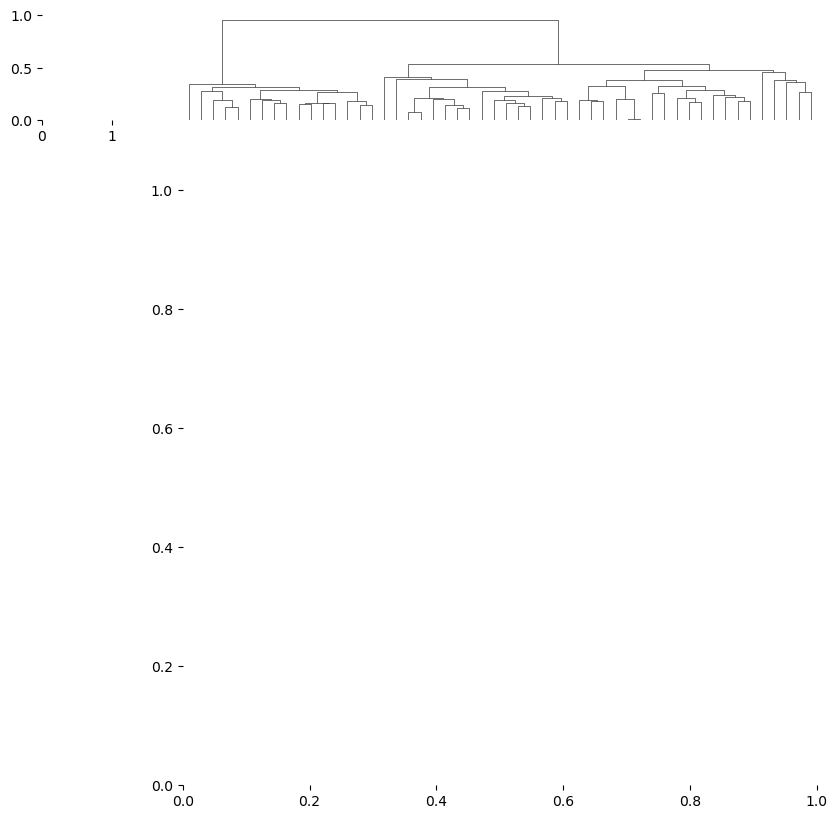

In [ ]:
#hierarchical clustering on the length dataset
#this is not working correctly atm for whatever reason, ill leave it be for now i think
#just don't worry about this for a bit lmao
#length_tocluster = length_tocluster.sort_index(axis=0)
#cmap_length = cluster_and_plot(length_tocluster)
sns.clustermap(length_tocluster, 
                method='ward', 
                metric='euclidean', 
                row_cluster=False,
                dendrogram_ratio=(.1, .15),
                cbar_pos=(0, .15, .03, .7),
                cbar_kws={'label': 'ln(terminals in region + 1)'},
                yticklabels=True,
                xticklabels=True)

In [ ]:
help(cmap)

Help on ClusterGrid in module seaborn.matrix object:

class ClusterGrid(seaborn.axisgrid.Grid)
 |  ClusterGrid(data, pivot_kws=None, z_score=None, standard_scale=None, figsize=None, row_colors=None, col_colors=None, mask=None, dendrogram_ratio=None, colors_ratio=None, cbar_pos=None)
 |  
 |  Method resolution order:
 |      ClusterGrid
 |      seaborn.axisgrid.Grid
 |      seaborn.axisgrid._BaseGrid
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, data, pivot_kws=None, z_score=None, standard_scale=None, figsize=None, row_colors=None, col_colors=None, mask=None, dendrogram_ratio=None, colors_ratio=None, cbar_pos=None)
 |      Grid object for organizing clustered heatmap input on to axes
 |  
 |  dim_ratios(self, colors, dendrogram_ratio, colors_ratio)
 |      Get the proportions of the figure taken up by each axes.
 |  
 |  format_data(self, data, pivot_kws, z_score=None, standard_scale=None)
 |      Extract variables from data or use directly.
 |  
 |  plo